In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import shap, datetime, warnings
warnings.filterwarnings('ignore')

In [2]:
# Open the pickle file
df = pickle.load(open('../../data/processed/merged_data_finance.pkl', 'rb'))

In [3]:
sentiment_cols = [i for i in df.columns if any(x in i for x in ['Article Count', 'Tone', 'llm'])] + [i for i in df.columns if i.startswith('c') or i.startswith('v')]
time_cols = ['hour_of_day_10','hour_of_day_11','hour_of_day_12','hour_of_day_13','hour_of_day_14','hour_of_day_15','hour_of_day_9','is_close','is_open','month_of_year_1','month_of_year_10','month_of_year_11','month_of_year_12','month_of_year_2','month_of_year_3','month_of_year_4','month_of_year_5','month_of_year_6','month_of_year_7','month_of_year_8','month_of_year_9','day_of_week_0','day_of_week_1','day_of_week_2','day_of_week_3','day_of_week_4']
self_finance_vars = [i for i in df.columns if 'lag' in i and i not in sentiment_cols and all(x not in i for x in ['BNO','JETS','IYT','ITA'])]
oil_vars          = [i for i in df.columns if 'lag' in i and 'BNO' in i]
etf_finance_vars  = [i for i in df.columns if 'lag' in i and i not in sentiment_cols and any(x in i for x in ['JETS','IYT','ITA'])]
finance_vars = self_finance_vars + oil_vars + etf_finance_vars

In [4]:
# Define the different sets of features to try
feature_sets = {
    'all': sentiment_cols + finance_vars + time_cols 
}

In [5]:
y_cols = ['Volume']
y = df[y_cols]

In [6]:
# Train/test splitting
split_val  = round(0.8 * len(y))
split_test = round(0.9 * len(y))

y_train = y[:split_val]
y_val   = y[split_val:split_test]
y_test  = y[split_test:]

In [7]:
predictions = df[['date','ticker','Volume']+time_cols]
predictions = predictions.iloc[split_val:, :]
predictions.rename(columns={'Volume': 'Actual'}, inplace=True)

In [8]:
# Add the tuned and retrained models as well
model = pickle.load(open(f'../../output/models/LightGBM/lightgbm_sentiment_only.pkl', 'rb'))

x_cols = feature_sets['all']
x = df[x_cols]
x_train = x[:split_val]
x_val   = x[split_val:split_test]
x_test  = x[split_test:]

# Normalize the features to [0,1]
sc2 = MinMaxScaler(feature_range=(0, 1))

x_train = sc2.fit_transform(x_train)
x_val   = sc2.transform(x_val)
x_test  = sc2.transform(x_test)
x_eval = np.concatenate((x_val, x_test), axis=0)

In [16]:
xt = pd.DataFrame(x_train, columns=x_cols)
xt['llm_dimension_00_cum96_lag01'].describe()

count    270230.000000
mean          0.093859
std           0.035941
min           0.000000
25%           0.072249
50%           0.084506
75%           0.103788
max           1.000000
Name: llm_dimension_00_cum96_lag01, dtype: float64

In [9]:
# sample 1000 rows from x_eval
np.random.seed(42)
x_sample = x_eval[np.random.choice(x_eval.shape[0], size=5000, replace=False), :]

In [10]:
# shap values
explainer = shap.TreeExplainer(model, x_sample, feature_names=x.columns)
shap_values = explainer(x_sample, check_additivity=False)

100%|===================| 4980/5000 [04:38<00:01]        

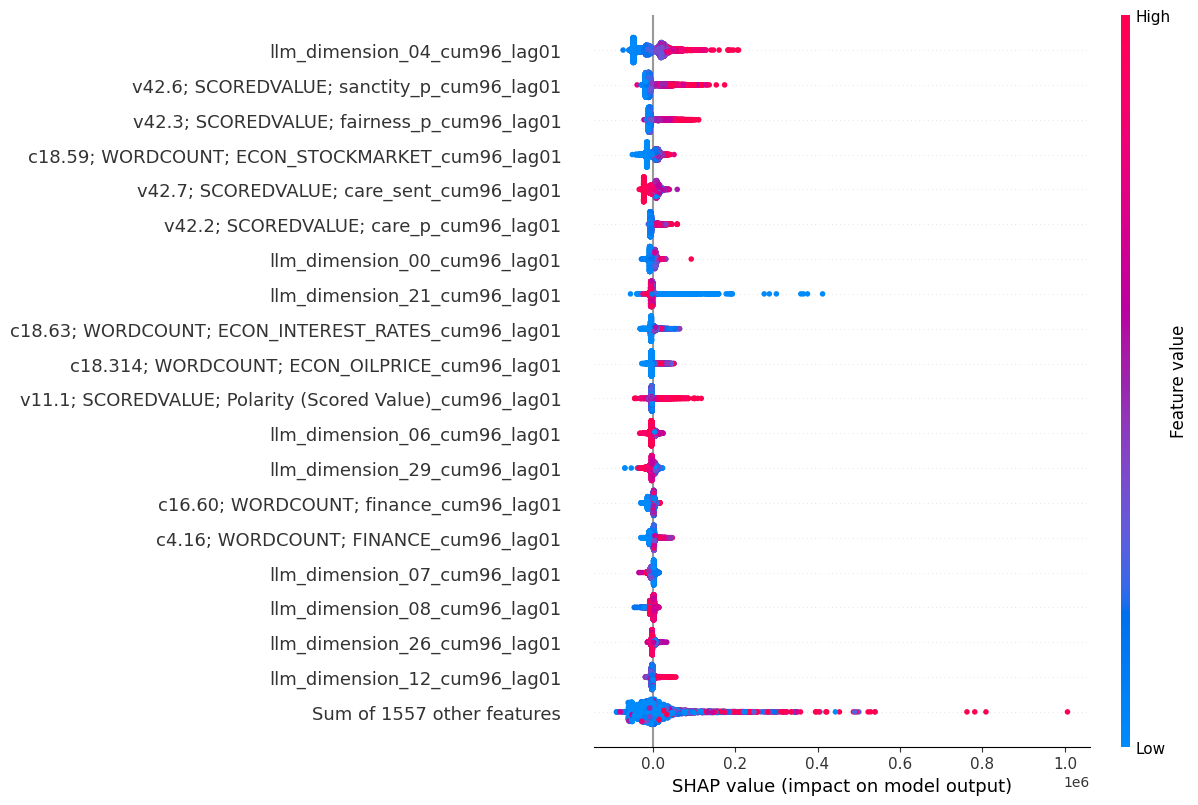

<Figure size 640x480 with 0 Axes>

In [11]:
shap.plots.beeswarm(shap_values, max_display=20)
plt.savefig('../../output/shap_beeswarm_sentiment.png', dpi=600)

In [15]:
df['llm_dimension_00_cum96_lag01'].describe()

count    337788.000000
mean          0.406184
std           0.489347
min          -0.854501
25%           0.116257
50%           0.284714
75%           0.543104
max          15.299085
Name: llm_dimension_00_cum96_lag01, dtype: float64

In [37]:
shap_values

.values =
array([[ 0.        ,  0.        ,  7.76464722, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  7.11321533, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  5.9464093 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        , 13.49613281, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  5.9464093 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  7.11321533, ...,  0.        ,
         0.        ,  0.        ]])

.base_values =
array([323605.47839129, 323605.47839129, 323605.47839129, ...,
       323605.47839129, 323605.47839129, 323605.47839129])

.data =
array([[0.01515152, 0.02392344, 0.0621118 , ..., 0.        , 1.        ,
        0.        ],
       [0.00757576, 0.00478469, 0.01242236, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        

In [34]:
shap_values[:, 4]

.values =
array([0., 0., 0., ..., 0., 0., 0.])

.base_values =
array([323605.47839129, 323605.47839129, 323605.47839129, ...,
       323605.47839129, 323605.47839129, 323605.47839129])

.data =
array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.00877193])

In [42]:
# Find the index position of the variable 'llm_dimension_04_cum96_lag01'
var = 'llm_dimension_04_cum96_lag01'
var_index = x.columns.get_loc(var)
var_index

33

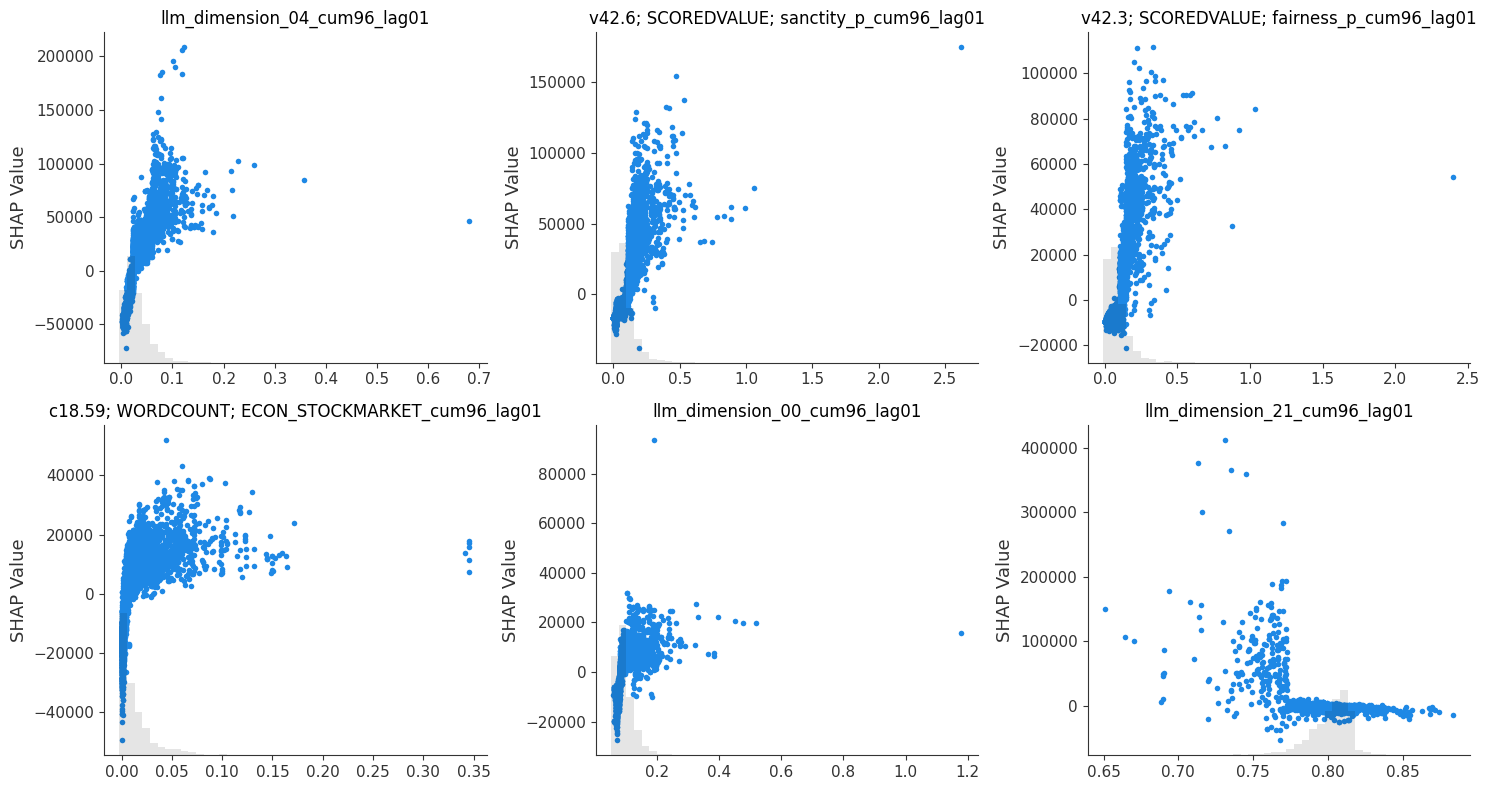

In [14]:
to_plot = ['llm_dimension_04_cum96_lag01', 'v42.6; SCOREDVALUE; sanctity_p_cum96_lag01', 'v42.3; SCOREDVALUE; fairness_p_cum96_lag01', 'c18.59; WORDCOUNT; ECON_STOCKMARKET_cum96_lag01', 'llm_dimension_00_cum96_lag01', 'llm_dimension_21_cum96_lag01']

# Calculate number of rows and columns for the subplot grid
n_plots = len(to_plot)
n_cols = 3  # You can adjust this based on your preference
n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division to ensure all plots fit

# Create a large figure
fig = plt.figure(figsize=(15, 4 * n_rows))

# Create and save each dependence plot
for i, var in enumerate(to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    shap.plots.scatter(
        shap_values[:, var],
        show=False,  # Don't show individual plots
        ax=plt.gca()
    )
    plt.title(f"{var}")
    plt.ylabel("SHAP Value")
    plt.xlabel("")

# Adjust layout
plt.tight_layout()

# Save combined figure
#plt.savefig(r'../output/gbm_shap_dependence_plots_combined.png', dpi=300, bbox_inches='tight')
plt.show()

(0.0, 0.3)

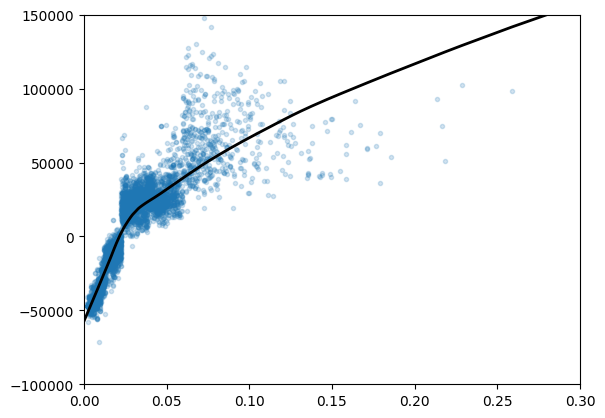

In [64]:
sns.regplot(
    x=shap_values[:, 33].data, 
    y=shap_values[:, 33].values,
    lowess=True,
    marker='.',
    scatter_kws={'alpha': 0.2},  # Adjust marker size and transparency
    line_kws={'color': 'black', 'linewidth': 2}  # Add a regression line
    )
plt.ylim(-100000,150000)
plt.xlim(0, 0.3)